In [214]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import inspect
from abc import ABC, abstractmethod
import time

在这个方法中，我们定义问题，问题中的的constrants 的数量，初始化sac中item的数量n，每个n对应的costs，utilities，population的size

In [215]:
class ParameterSetting:
    def __init__(self, n, k, population_size):
        self.n = n  # 物体的数量
        self.k = k  # 成本约束的数量
        self.population_size = population_size  # 种群大小
        np.random.seed(1)  # 确保每次生成的随机数相同
        self.B = np.random.randint(100, 200, size=(self.k))  # 每个约束的预算
        self.utilities = np.random.randint(1, 100, size=self.n)  # 每个物体的效用值
        self.costs = np.random.randint(1, 20, size=(self.n, self.k))  # 每个物体的成本
    
    def print_info(self):
        # 打印预算和物体列表
        cost_columns = [f"cost_{i+1}" for i in range(self.k)]
        print("Liste de budgets:")
        print(self.B)
        df = pd.DataFrame(
            np.column_stack((self.utilities, self.costs)),
            columns=["utilities"] + cost_columns,
        )
        print("Liste d'objets:")
        print(df)

一个population代表多个solution的集合，每一个population含有以下的特性 ：1.fitness_moyen 2.fintness_max 3.best_solution 4.fiteness_variation

In [216]:
class Population:
    def __init__(self, size, individuals, fitness_func):
        self.size = size
        self.individuals = individuals
        self.fitness_func = fitness_func  # 传递适应度函数
        self.fitness_scores = np.zeros(size)
        self.evaluate_fitness()

    def evaluate_fitness(self):
        # 计算每个个体的适应度值，并将结果存储在 self.fitness_scores 中
        self.fitness_scores = np.array([self.fitness_func(ind) for ind in self.individuals])

    def get_max_fitness(self):
        return np.max(self.fitness_scores)

    def get_avg_fitness(self):
        return np.mean(self.fitness_scores)

    def get_var_fitness(self):
        return np.var(self.fitness_scores)

    def get_best_individual(self):
        max_index = np.argmax(self.fitness_scores)
        return self.individuals[max_index], self.fitness_scores[max_index]

定义了一个抽象方法

In [217]:
class GeneticAlgorithm():
    def __init__(self, parameter_setting,select_func,crossover_func,mutate_func):
        self.parameter_setting = parameter_setting
        self.n = parameter_setting.n
        self.k = parameter_setting.k
        self.population_size = parameter_setting.population_size
        self.B = parameter_setting.B
        self.utilities = parameter_setting.utilities
        self.costs = parameter_setting.costs
        self.population = self.initialize_population()
        self.max_fitness_history = []
        self.avg_fitness_history = []
        self.variance_fitness_history = []
        self.select = select_func
        self.crossover = crossover_func
        self.mutate = mutate_func

    def initialize_population(self):
        individuals = np.random.randint(2, size=(self.population_size, self.n))
        return Population(self.population_size, individuals, self.fitness)

    def cost(self, solution):
        total_cost = solution @ self.costs
        return total_cost

    def fitness(self, solution):
        total_utility = np.sum(solution * self.utilities)
        total_cost = self.cost(solution)
        if np.any(total_cost > self.B):
            return 0  # 违反约束，适应度为0
        return total_utility

    
    def repair(self, solution):
        while any(
            np.dot(solution, self.costs[:, j]) > self.B[j] for j in range(self.k)
        ):
            for i in reversed(range(self.n)):
                if solution[i] == 1 and any(
                    np.dot(solution, self.costs[:, j]) > self.B[j]
                    for j in range(self.k)
                ):
                    solution[i] = 0
        return solution

    def run(self, generations):
        self.max_fitness_history = []
        self.avg_fitness_history = []
        self.variance_fitness_history = []

        for generation in range(generations):
            new_individuals = []
            for _ in range(self.population_size // 2):
                parent1 = self.select(self.population,self.fitness)
                parent2 = self.select(self.population,self.fitness)
                child1 = self.crossover(parent1, parent2)
                child2 = self.crossover(parent1, parent2)
                 # 动态检查 mutate 方法的参数数量
                 
                mutate_params = inspect.signature(self.mutate).parameters
                if len(mutate_params) == 1:
                    child1 = self.mutate(child1)
                    child2 = self.mutate(child2)
                elif len(mutate_params) == 3:
                    child1 = self.mutate(child1, self.fitness, self.population)
                    child2 = self.mutate(child2, self.fitness, self.population)
                else:
                    raise ValueError("Unexpected number of parameters for mutate function")

               
                child1 = self.repair(child1)
                child2 = self.repair(child2)
                new_individuals.extend([child1, child2])

            self.population = Population(self.population_size, np.array(new_individuals), self.fitness)
            self.population.evaluate_fitness()  # 评估新种群的适应度
            self.max_fitness_history.append(self.population.get_max_fitness())
            self.avg_fitness_history.append(self.population.get_avg_fitness())
            self.variance_fitness_history.append(self.population.get_var_fitness())
        return self.population

    def solution(self, generations):
        self.run(generations)
        best_individual, best_fitness = self.population.get_best_individual()
        return best_individual
    
    def get_plot_data(self):
        return {
            'max_fitness': self.max_fitness_history,
            'avg_fitness': self.avg_fitness_history,
            'variance_fitness': self.variance_fitness_history
        }
    
    def run_multiple_instances(self, generations, num_instances):
        all_max_fitness = np.zeros((num_instances, generations))  # 创建一个二维数组，形状为(num_instances, generations)，用于存储每个实例在每一代的最大适应度值。
         # 循环运行多个实
        for i in range(num_instances):
         # 初始化种群
            self.population = self.initialize_population()
        # 运行遗传算法
            self.run(generations)
        # 存储当前实例每一代的最大适应度值
            all_max_fitness[i] = self.max_fitness_history

        avg_max_fitness = np.mean(all_max_fitness, axis=0)
        std_max_fitness = np.std(all_max_fitness, axis=0)
        return avg_max_fitness, std_max_fitness


In [218]:
# 选择策略一：适应度越大，被选为父母的概率越大
def select_fitness_proportional(population, fitness_func):
    fitnesses = np.array([fitness_func(individual) for individual in population.individuals])
    probabilities = fitnesses / fitnesses.sum()
    index = np.random.choice(range(len(population.individuals)), p=probabilities)
    return population.individuals[index]

# 选择策略二：锦标赛选择
def select_tournament(population, fitness_func):
    tournament_size=5
    selected_indices = np.random.choice(len(population.individuals), tournament_size, replace=False)
    selected = [population.individuals[i] for i in selected_indices]
    fitnesses = [fitness_func(individual) for individual in selected]
    winner = selected[np.argmax(fitnesses)]
    return winner

# 交叉策略一：随机交叉
def crossover_random(parent1, parent2):
    child = np.array([parent1[i] if random.random() > 0.5 else parent2[i] for i in range(len(parent1))])
    return child

# 交叉策略二：两点交叉
def crossover_two_point(parent1, parent2):
    point1, point2 = sorted(np.random.choice(range(len(parent1)), 2, replace=False))
    child = np.concatenate((parent1[:point1], parent2[point1:point2], parent1[point2:]))
    return child

# 变异策略一：单点变异
def mutate_single_point(individual):
    index = np.random.randint(len(individual))
    individual[index] = 1 - individual[index]
    return individual

# 变异策略二：适应度比例变异
def mutate_fitness_proportional(individual, fitness_func, population):
    mutation_prob = 0.1  # 基础变异概率
    fitness = fitness_func(individual)
    avg_fitness = np.mean([fitness_func(ind) for ind in population.individuals])
    if fitness < avg_fitness:
        mutation_prob *= 2  # 低于平均适应度的个体增加变异概率
    for i in range(len(individual)):
        if np.random.rand() < mutation_prob:
            individual[i] = 1 - individual[i]
    return individual

In [219]:
n = 10  # Nombre d'objets
k = 3  # Nombre de contraintes de coût
population_size = 20
parameterSetting = ParameterSetting(n,k,population_size)
parameterSetting.print_info()   

Liste de budgets:
[137 112 172]
Liste d'objets:
   utilities  cost_1  cost_2  cost_3
0         10      19       6      19
1         76      12      11      15
2          6      19       5      10
3         80      18       1      14
4         65      10      10       8
5         17       2       1      18
6          2       9      14      16
7         77      11       9       8
8         72       4       7      18
9          7       4       5      18


Testing select_fitness_proportional, crossover_random, mutate_single_point
Max Average Fitness: 406.0


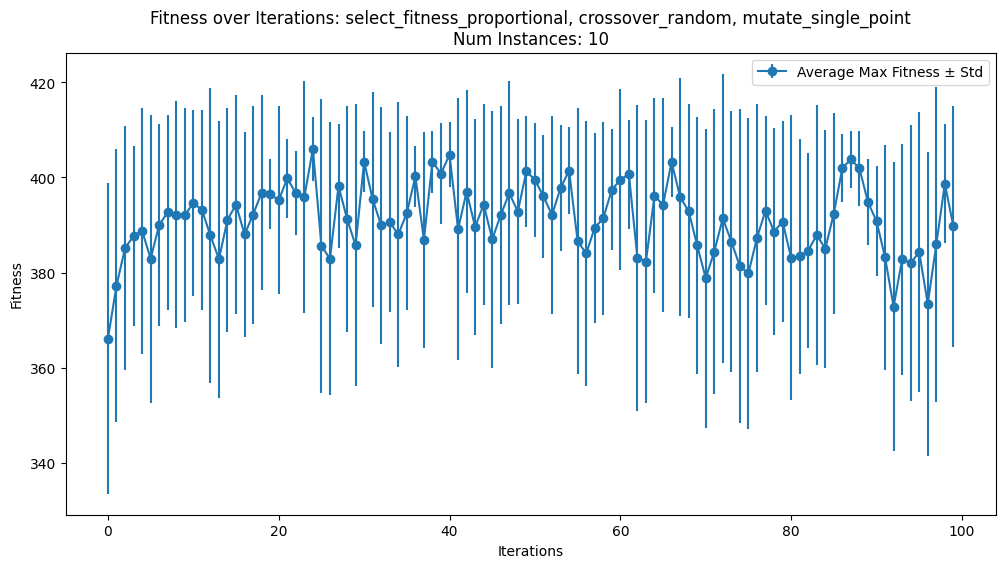

Elapsed Time: 7.04 seconds
----------------------------------------------------------------
Testing select_fitness_proportional, crossover_random, mutate_fitness_proportional
Max Average Fitness: 405.2


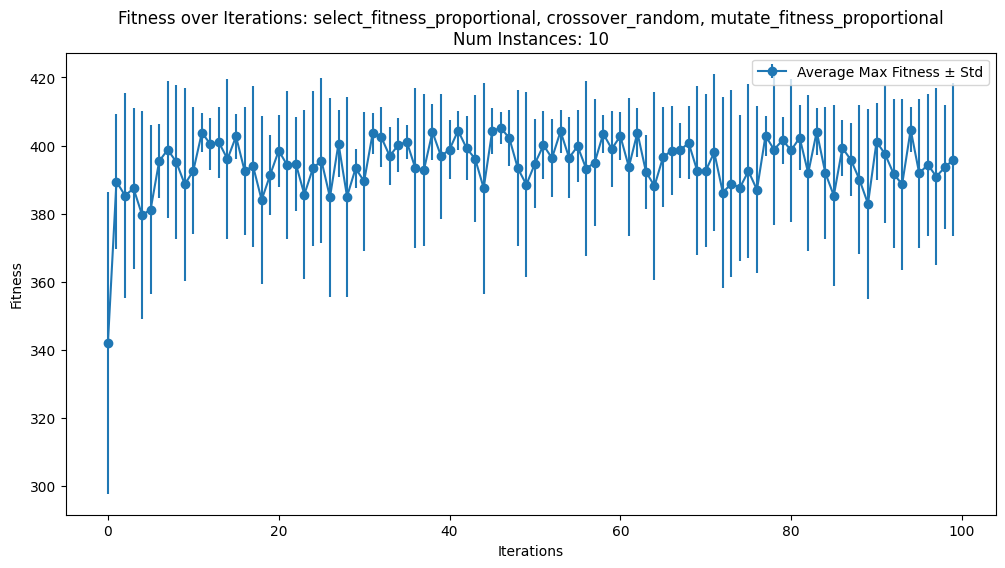

Elapsed Time: 11.81 seconds
----------------------------------------------------------------
Testing select_fitness_proportional, crossover_two_point, mutate_single_point
Max Average Fitness: 403.0


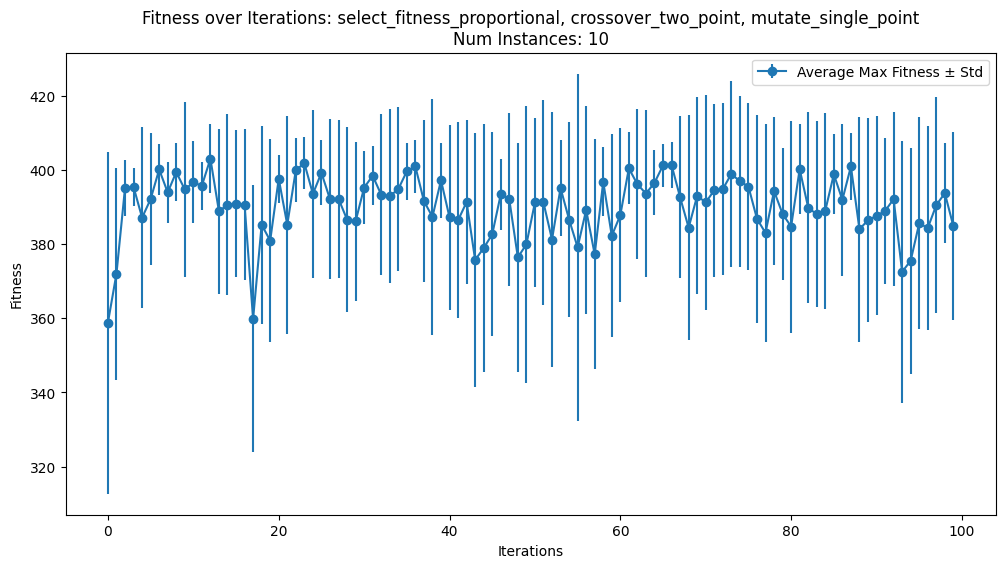

Elapsed Time: 7.36 seconds
----------------------------------------------------------------
Testing select_fitness_proportional, crossover_two_point, mutate_fitness_proportional
Max Average Fitness: 405.9


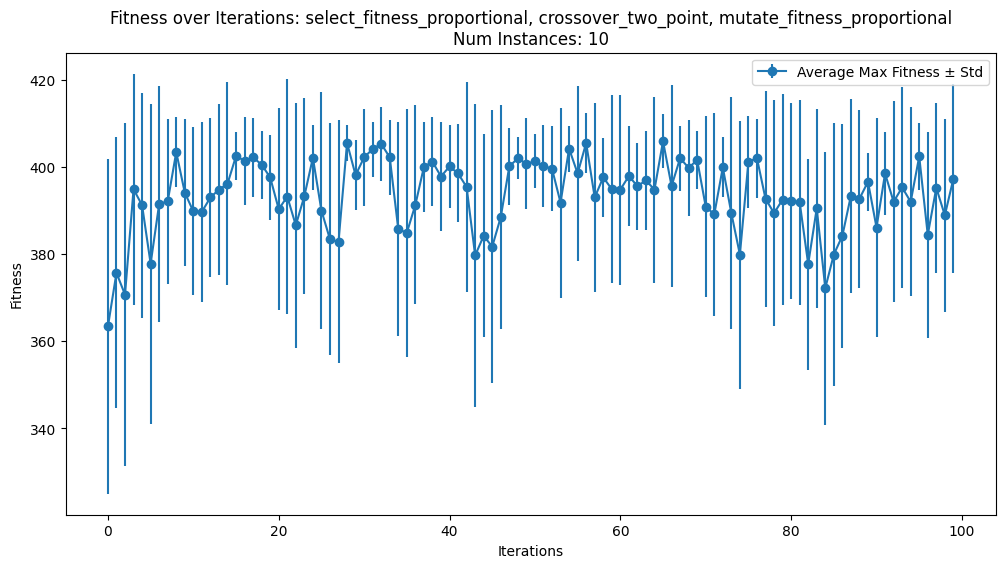

Elapsed Time: 12.38 seconds
----------------------------------------------------------------
Testing select_tournament, crossover_random, mutate_single_point
Max Average Fitness: 411.8


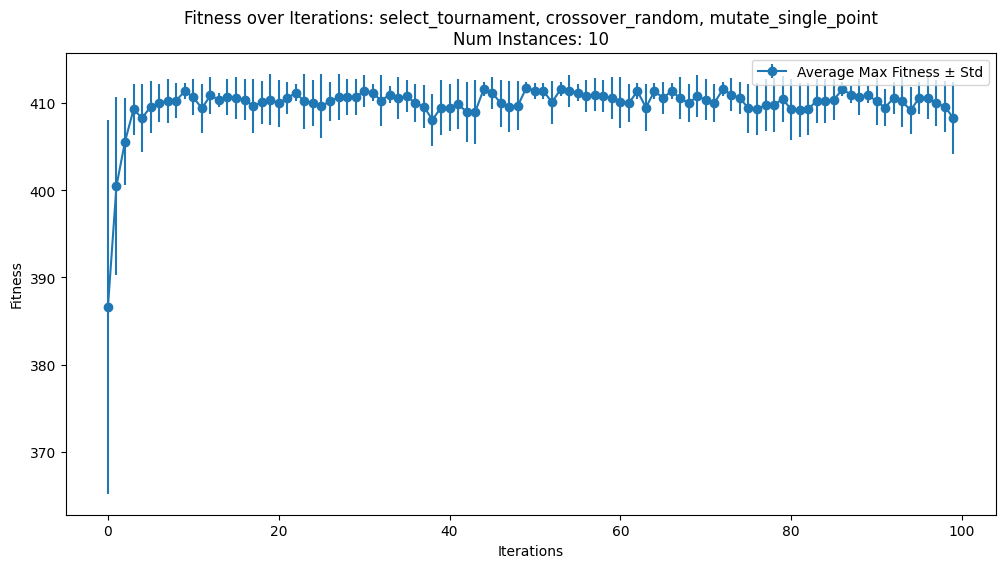

Elapsed Time: 3.11 seconds
----------------------------------------------------------------
Testing select_tournament, crossover_random, mutate_fitness_proportional
Max Average Fitness: 412.0


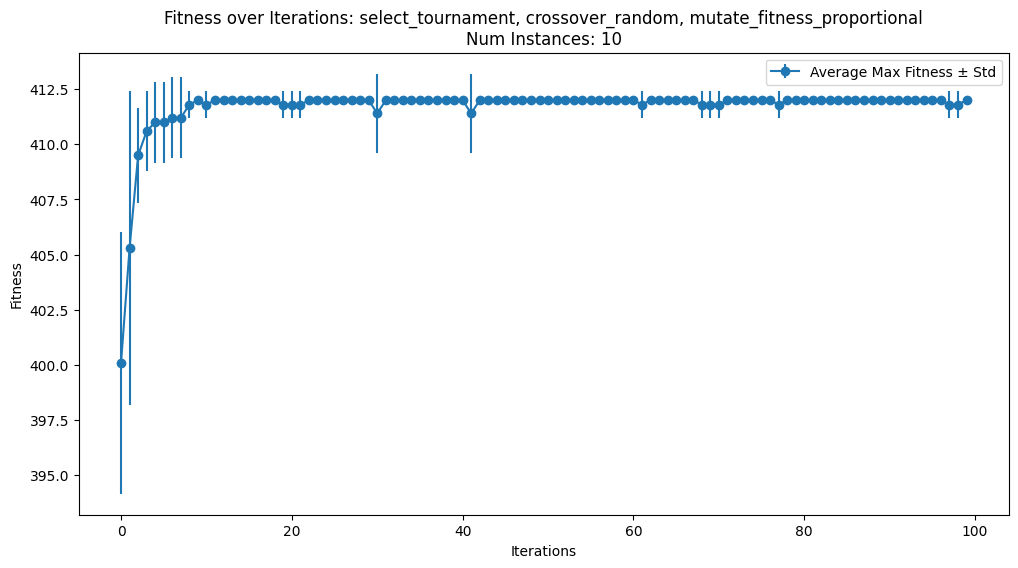

Elapsed Time: 8.07 seconds
----------------------------------------------------------------
Testing select_tournament, crossover_two_point, mutate_single_point
Max Average Fitness: 411.6


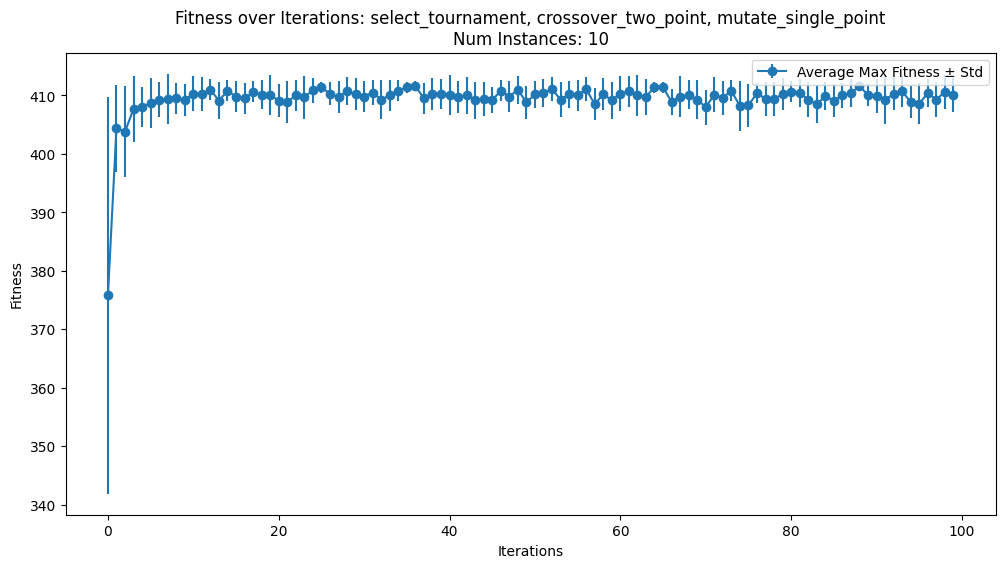

Elapsed Time: 3.77 seconds
----------------------------------------------------------------
Testing select_tournament, crossover_two_point, mutate_fitness_proportional
Max Average Fitness: 412.0


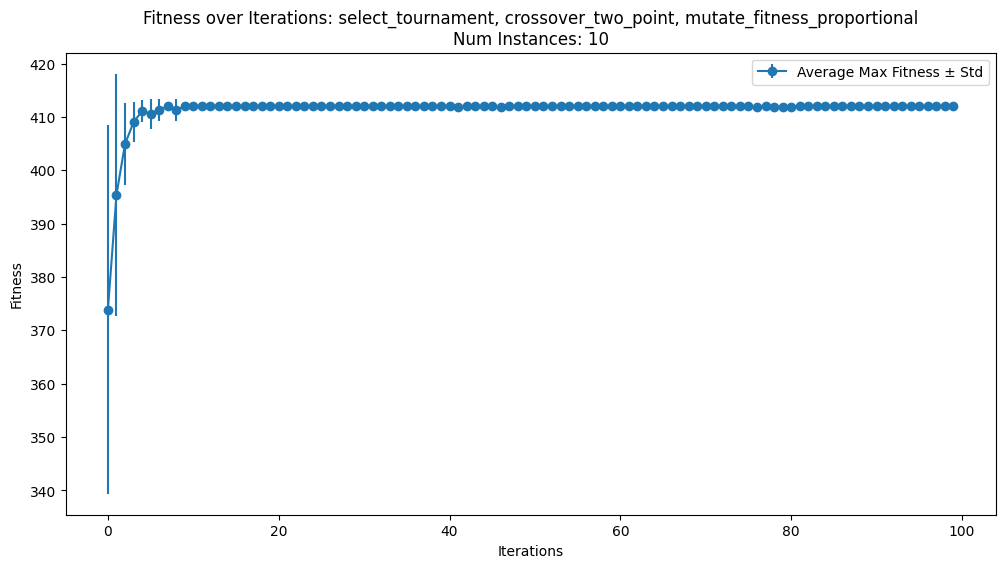

Elapsed Time: 8.69 seconds
----------------------------------------------------------------


In [220]:
parameter_setting = ParameterSetting(n, k, population_size)

# 测试不同的选择、交叉和变异策略组合
select_functions = [select_fitness_proportional, select_tournament]
crossover_functions = [crossover_random, crossover_two_point]
mutate_functions = [mutate_single_point, mutate_fitness_proportional]

for select_func in select_functions:
    for crossover_func in crossover_functions:
        for mutate_func in mutate_functions:
            print(f"Testing {select_func.__name__}, {crossover_func.__name__}, {mutate_func.__name__}")
            ga = GeneticAlgorithm(parameter_setting, select_func, crossover_func, mutate_func)
            nombre_iteration = 100
            num_instances = 10  # 实例数量

            start_time = time.time()
            avg_max_fitness, std_max_fitness = ga.run_multiple_instances(nombre_iteration, num_instances)
            end_time = time.time()
            elapsed_time = end_time - start_time

            # 输出算法得到的最大的平均 fitness
            max_avg_fitness = np.max(avg_max_fitness)
            print(f"Max Average Fitness: {max_avg_fitness}")

            # 绘图
            def plot_multiple_instances(ga, avg_max_fitness, std_max_fitness, iterations, num_instances):
                plt.figure(figsize=(12, 6))
                plt.errorbar(range(iterations), avg_max_fitness, yerr=std_max_fitness, label='Average Max Fitness ± Std', fmt='-o')
                plt.xlabel('Iterations')
                plt.ylabel('Fitness')
                plt.title(f'Fitness over Iterations: {select_func.__name__}, {crossover_func.__name__}, {mutate_func.__name__}\nNum Instances: {num_instances}')
                plt.legend()
                plt.show()

            plot_multiple_instances(ga, avg_max_fitness, std_max_fitness, nombre_iteration, num_instances)
            
            # 输出运行时间
            print(f"Elapsed Time: {elapsed_time:.2f} seconds")
            #print(f"Average Max Fitness: {avg_max_fitness} ± {std_max_fitness}")
            print("----------------------------------------------------------------")
